In [38]:
# import from the scientific stack
from pyspots import io
from pyspots.data import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, IntSlider

# and import from the pyspots library
from pyspots.fit import init_default_avrami_model, avrami_func, do_fit
from pyspots.vis import plot_fit_against_full_dataset


In [2]:
# Define the path to your Ramdog output data that you want to load 
# path_to_spot_data = 'C:/Users/JDM_1/Documents/APS Feb15/d0 glass/90-FQ-C_2/90-FQ-C_2/spots90FQ2_normalized_spot.txt' 
path_to_spot_data = 'threshold-50all_normalized_spot.txt'
# And load the data into memory
spot_growth = io.read_normalized_file(path_to_spot_data)
# Turn the spot data into a table, so we can easily take the rolling mean
df = pd.DataFrame({spot.idx: spot.data for spot in spot_growth}, index=spot_growth[0].times)

In [3]:
window_size=3
averaged = pd.rolling_mean(df, window=window_size)[window_size-1:]

C:\Users\edill\AppData\Local\Continuum\Miniconda3\envs\pyspots\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=3).mean()
  from ipykernel import kernelapp as app


In [4]:
# compute the average min/max
avg_min = averaged.head(5).mean()
avg_max = averaged.tail(5).mean()

In [5]:
normalized = (averaged - avg_min) / (avg_max - avg_min)

## Make an interactive widget to show the normalized data

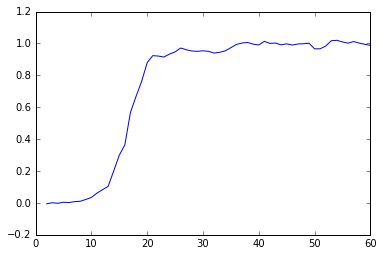

In [58]:
def plot_normalized(x):
    plt.plot(normalized[x])
interact(plot_normalized, x=IntSlider(min=0, max=len(normalized.columns)-1))

## Fit the data

In [81]:
fit = {}
print('0 ')
for idx, col_name in enumerate(normalized):
    if idx % 20 == 0:
        print('*',end='', sep='')
    col = normalized[col_name]
    times = col.index
    data = col.values
    # do_fit now takes the following keyword arguments:
    # t0 : the starting t0
    # n : the starting n
    # kA : the starting kA
    # If you want to turn on or off fitting a given parameter, pass in:
    # vary_t0=False or vary_n=True, etc.
    # The default values are to fix n and fit kA/t0
    fits = do_fit(times, data, t0=10, kA=0.1)
    fit[col_name] = fits

0 
*************************************

## Make an interactive widget to show the fit data

<function __main__.plot_normalized>

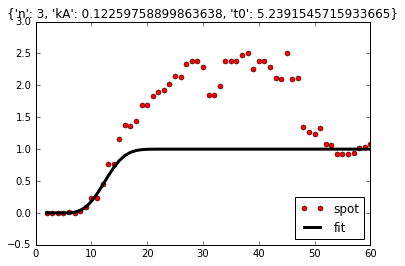

In [89]:
def plot_normalized(col_name):
    fig, ax = plt.subplots()
    x = normalized[col_name].index
    y = normalized[col_name][:]
    ax.plot(x, y, marker='o', markersize=5, 
            markerfacecolor='red', linestyle='None',
           label='spot')
    fit_result = fit[col_name][-1]
    fit_params = fit_result.best_values
    fit_values = avrami_func(x, **fit_params)
    fit_values[x < fit_params['t0']] = 0
    ax.plot(x, fit_values, linewidth=3, marker='None', color='k',
           label='fit')
    ax.set_title(str(fit_params))
    ax.legend(loc=4)
interact(plot_normalized, col_name=IntSlider(min=0, max=len(normalized.columns)-1))

In [90]:
params = {}
metadata_keys = [k for k in spot_growth[0]._fields if k not in ['data', 'times']]
for spot_idx, f in fit.items():
    dct = {'iterations': len(f)}
    dct.update(f[-1].best_values)
    dct.update({k: getattr(spot_growth[spot_idx], k) for k in metadata_keys})
    params[spot_idx] = dct
# params = {spot_idx: f[-1].best_values.update({'iterations': len(f)}) for spot_idx, f in fit.items()}

In [91]:
params[0]

{'idx': 0,
 'iterations': 3,
 'kA': 0.12259758899863638,
 'n': 3,
 'phi': '200.68',
 'q': '6.56',
 't0': 5.2391545715933665,
 'x': '7.575992779783394',
 'y': '682.0310469314079'}

In [92]:
param_data = pd.DataFrame(params).T

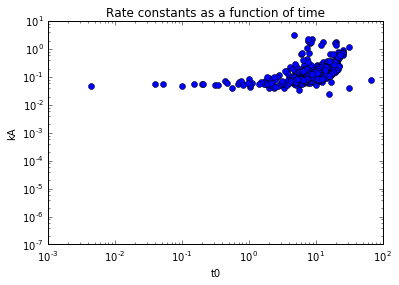

In [93]:
fig, ax = plt.subplots()
ax.loglog(param_data.t0, param_data.kA, 'o')
ax.set_xlabel('t0')
ax.set_ylabel('kA')
ax.set_title('Rate constants as a function of time')
param_data.to_csv('90FQ.csv')

In [80]:
param_data

,idx,iterations,kA,n,phi,q,t0,x,y
0,0,2,1.14432,3,200.68,6.56,-1670.79,7.575992779783394,682.0310469314079
1,1,2,0.0786311,3,203.14,6.66,-525.321,8.387295081967213,632.6209016393443
2,2,2,0.0685538,3,173.91,6.12,-505.425,17.603091115067162,1164.4434374494256
3,3,2,0.149658,3,169.03,6.17,-645.91,21.44955561456397,1249.8978616391496
4,4,2,0.122307,3,146.67000000000002,7.18,-603.936,25.218650741132876,1703.89329671784
5,5,2,0.123783,3,185.16,6.06,-605.484,26.507530304885513,970.5682625198972
6,6,2,0.0967795,3,204.07999999999998,6.56,-563.038,31.431613819214387,623.528395646001
7,7,2,0.114743,3,182.11,6.01,-592,31.52831502013623,1023.1708845025605
8,8,2,0.136746,3,137.32,8.06,-626.189,31.544402242720203,1957.4281063483452
9,9,2,0.151838,3,221.44,7.91,-652.582,32.388377037562016,199.46509567682494
